In [1]:
# default_exp moe

# Merit Order Effect Analysis

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import pickle
from sklearn import linear_model
from collections.abc import Iterable

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda
from moepy.surface import PicklableFunction

<br>

### User Inputs

In [3]:
model_fp = '../data/models/weekly_price_curve.pkl'
load_existing_model = False

<br>

### Estimating the Price Surface

In [4]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 2.29 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


Text(0, 0.5, 'Day-Ahead Price\nMonthly Average (£/MWh)')

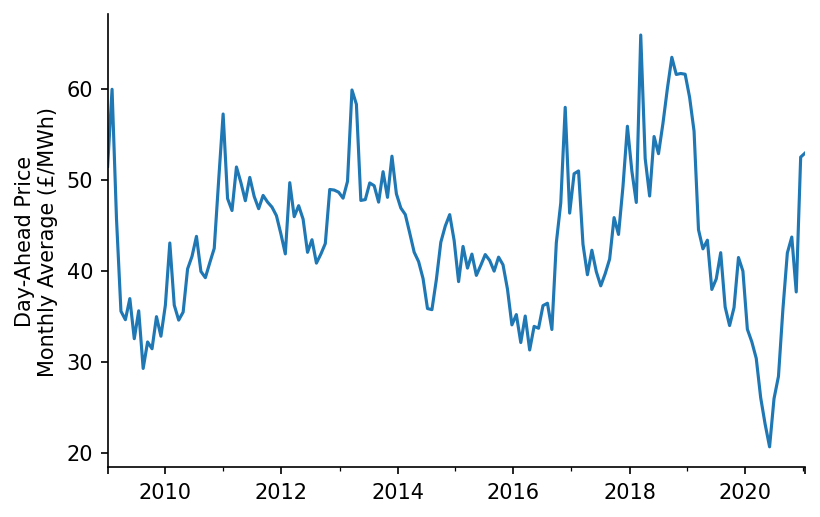

In [5]:
fig, ax = plt.subplots(dpi=150)

df_EI['day_ahead_price'].resample('4W').mean().plot(ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Day-Ahead Price\nMonthly Average (£/MWh)')

Text(0, 0.5, 'Price (£/MWh)')

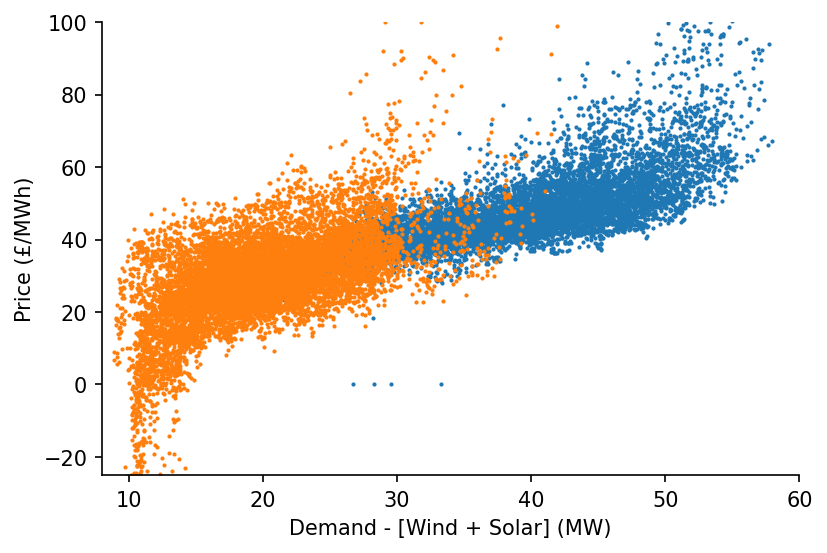

In [6]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

In [7]:
%%time

if load_existing_model == False:
    smooth_dates = pickle.load(open(model_fp, 'rb'))
else:
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)
    
    pickle.dump(smooth_dates, open(model_fp, 'wb'))

Wall time: 3 s


In [8]:
%%time

x_pred = np.linspace(3, 61, 581)
dt_pred = pd.date_range('2009-01-01', '2020-12-29', freq='1D')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
df_pred.index = np.round(df_pred.index, 1)

df_pred.head()

Wall time: 812 ms


,2009-01-01,2009-01-02,2009-01-03,2009-01-04,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-10,...,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29
3.0,-18.660151,-18.675685,-18.691066,-18.706293,-18.721366,-18.736281,-18.751037,-18.765631,-18.780059,-18.794319,...,-5.068528,-5.061855,-5.055104,-5.048274,-5.041366,-5.034378,-5.027312,-5.020166,-5.012942,-5.005639
3.1,-18.465054,-18.480529,-18.495852,-18.511021,-18.526037,-18.540897,-18.555597,-18.570135,-18.584509,-18.598716,...,-4.821083,-4.814403,-4.807644,-4.800807,-4.793892,-4.786897,-4.779824,-4.772673,-4.765443,-4.758134
3.2,-18.269955,-18.285372,-18.300637,-18.315749,-18.330708,-18.345511,-18.360156,-18.374639,-18.388959,-18.403112,...,-4.573691,-4.567003,-4.560237,-4.553393,-4.546470,-4.539469,-4.532390,-4.525232,-4.517996,-4.510681
3.3,-18.074856,-18.090214,-18.105421,-18.120476,-18.135378,-18.150125,-18.164714,-18.179142,-18.193407,-18.207506,...,-4.326362,-4.319666,-4.312892,-4.306041,-4.299111,-4.292103,-4.285017,-4.277853,-4.270611,-4.263290
3.4,-17.879755,-17.895055,-17.910203,-17.925200,-17.940046,-17.954736,-17.969270,-17.983643,-17.997853,-18.011899,...,-4.079104,-4.072401,-4.065619,-4.058760,-4.051823,-4.044808,-4.037716,-4.030545,-4.023297,-4.015971


<br>

### Visualising the Price Surface

Text(0.5, 1.0, 'Day-Ahead Market Average Price Curve')

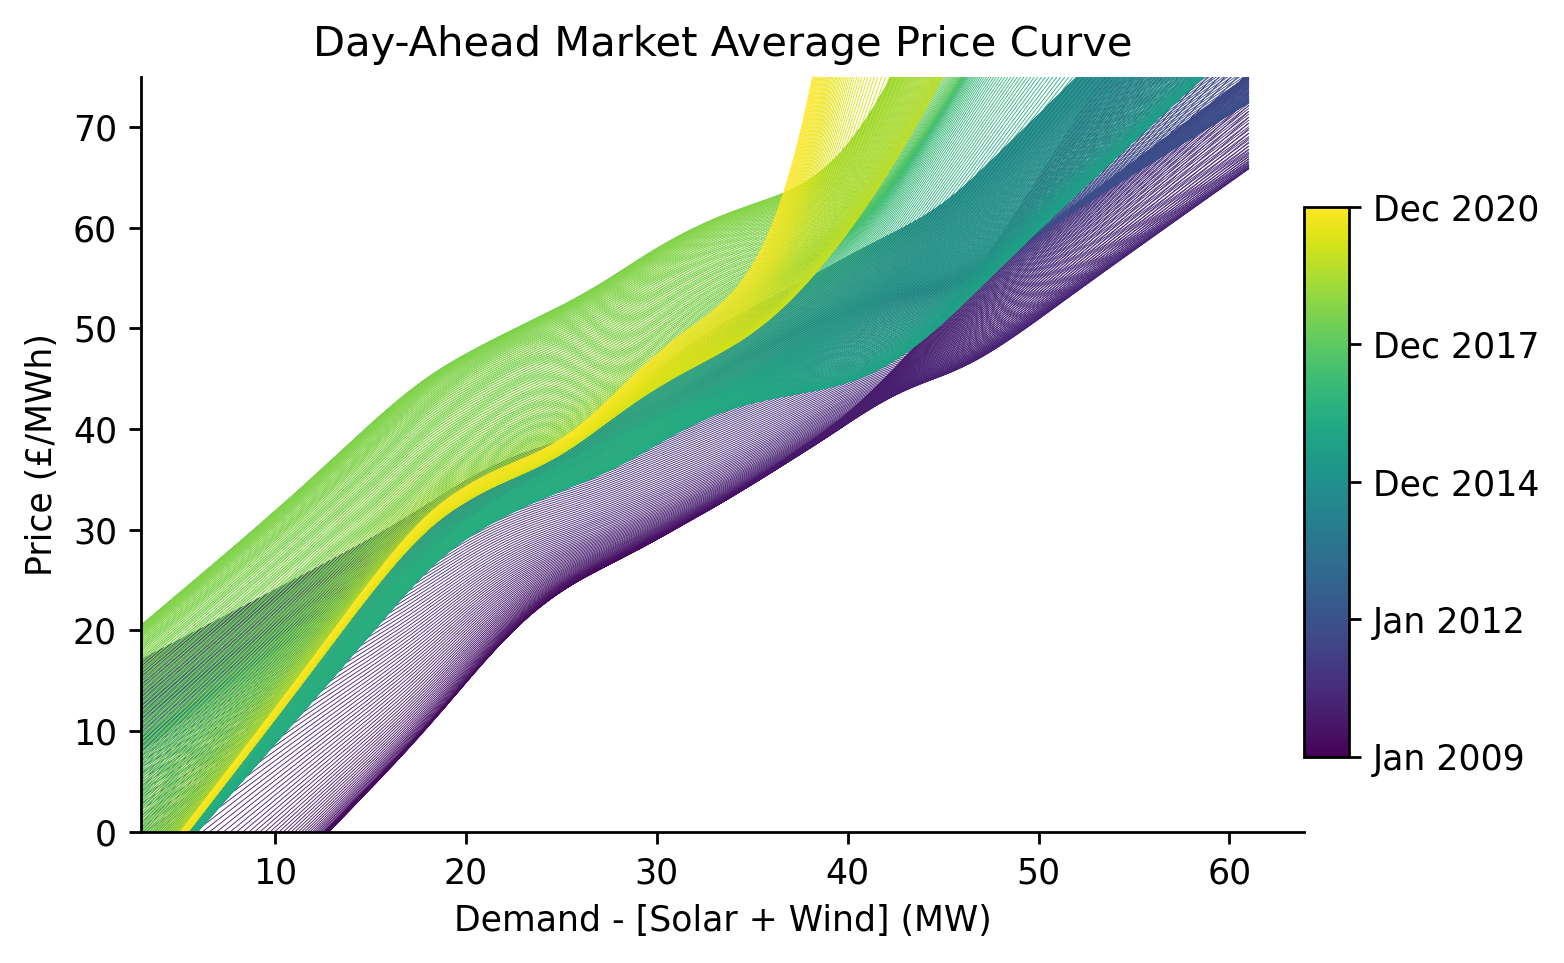

In [9]:
cmap = plt.get_cmap('viridis')
cbar_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plotting
fig, ax = plt.subplots(dpi=250)

lp = df_pred.loc[:, ::7].plot(legend=False, cmap=cmap, linewidth=0.25, ax=ax)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.55])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', cmap=cmap, ticks=cbar_ticks)
cbar.ax.set_yticklabels([dt_pred[min(int(len(dt_pred)*tick_loc), len(dt_pred)-1)].strftime('%b %Y') for tick_loc in cbar_ticks])

hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.index[0])
ax.set_ylim(0, 75)
ax.set_title('Day-Ahead Market Average Price Curve')

<AxesSubplot:>

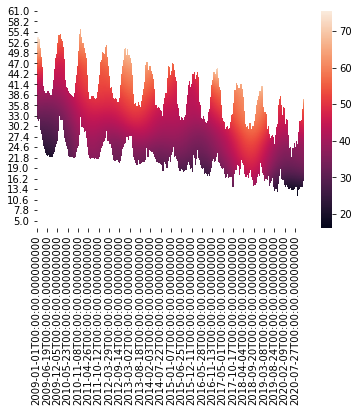

In [10]:
rolling_w = 3

df_dispatchable_lims = (s_dispatchable
                        .resample('1d')
                        .quantile([0.001, 0.999])
                        .unstack()
                        .rolling(rolling_w*7)
                        .mean()
                        .bfill()
                        .ffill()
                        .iloc[:-1, :]
                       )

df_dispatchable_lims.index = pd.to_datetime(df_dispatchable_lims.index.strftime('%Y-%m-%d'))

df_pred_mask = pd.DataFrame(dict(zip(df_pred.columns, [df_pred.index]*df_pred.shape[1])), index=df_pred.index)
df_pred_mask = (df_pred_mask > df_dispatchable_lims.iloc[:, 0].values) & (df_pred_mask < df_dispatchable_lims.iloc[:, 1].values)

df_pred.columns = pd.to_datetime(df_pred.columns)
df_pred_mask.columns = pd.to_datetime(df_pred_mask.columns)

sns.heatmap(df_pred.where(df_pred_mask, np.nan).iloc[::-1])

In [11]:
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))
    
    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

Text(69.58333333333334, 0.5, 'Demand - [Solar + Wind] (GW)')

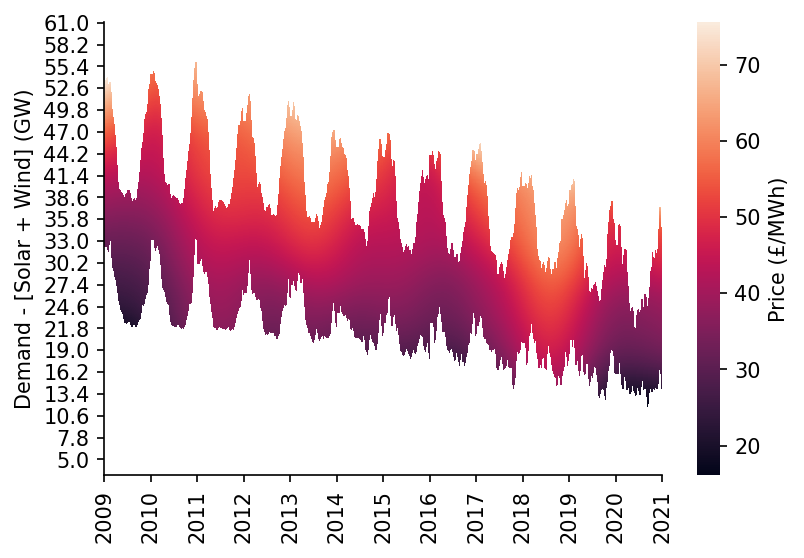

In [12]:
fig, ax = plt.subplots(dpi=150)

htmp = sns.heatmap(df_pred.where(df_pred_mask, np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Price (£/MWh)'})

set_date_ticks(ax, '2009-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
hlp.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

Wall time: 75 ms


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Text(0, 0.5, 'Day-Ahead Price (£/MWh)')

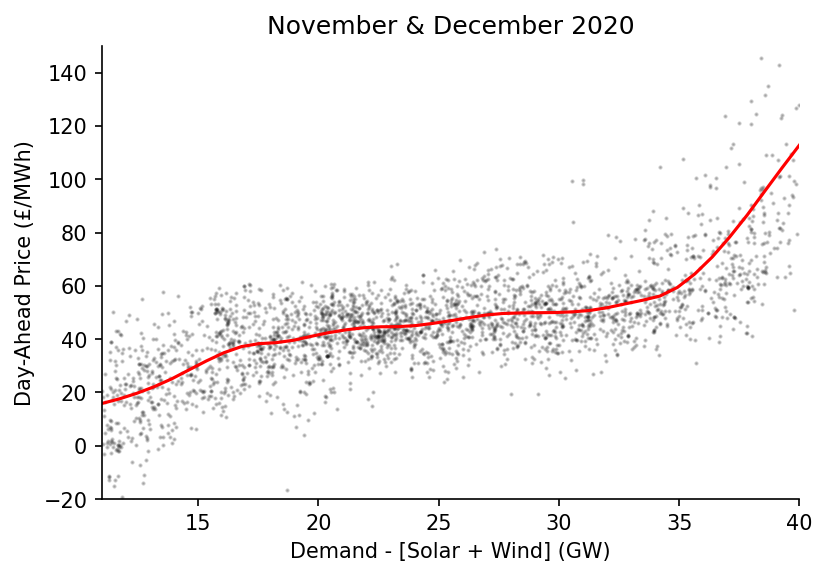

In [265]:
%%time

center_date = '2020-12-01'

dt_min = pd.to_datetime(center_date) - pd.Timedelta(weeks=4)
dt_max = pd.to_datetime(center_date) + pd.Timedelta(weeks=4)

x = s_dispatchable[dt_min:dt_max].values
y = s_price.loc[s_dispatchable.index][dt_min:dt_max].values

x_pred = np.linspace(11, 40, 41)
y_pred = lowess.lowess_fit_and_predict(x, y, frac=0.25, num_fits=25, x_pred=x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, linewidth=1.5, color='r')
ax.scatter(x, y, color='k', s=1, alpha=0.2)

ax.set_title(f'November & December 2020') # remove in the LaTeX plot and just state in the caption
ax.set_xlim(11, 40)
ax.set_ylim(-20, 150)
hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')

<br>

### Evaluating the Price Curve Predictions

In [14]:
#exports
def construct_df_pred(model_fp, x_pred=np.linspace(-2, 61, 631), dt_pred=pd.date_range('2009-01-01', '2020-12-29', freq='1D')):
    smooth_dates = pickle.load(open(model_fp, 'rb'))
    df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
    df_pred.index = np.round(df_pred.index, 1)
    
    return df_pred

In [15]:
model_fp = '../data/models/DAM_price_demand_average.pkl'

df_pred = construct_df_pred(model_fp)

df_pred.head()

,2009-01-01,2009-01-02,2009-01-03,2009-01-04,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-10,...,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29
-2.0,-20.137343,-20.152378,-20.167253,-20.181966,-20.196517,-20.210901,-20.225114,-20.239151,-20.253008,-20.266681,...,19.780043,19.782141,19.784266,19.786419,19.788599,19.790806,19.793042,19.795304,19.797595,19.799913
-1.9,-19.978367,-19.993355,-20.008183,-20.022850,-20.037356,-20.051696,-20.065865,-20.079858,-20.093672,-20.107302,...,19.792214,19.794308,19.796429,19.798578,19.800754,19.802958,19.805189,19.807448,19.809735,19.812049
-1.8,-19.819329,-19.834271,-19.849052,-19.863674,-19.878134,-19.892429,-19.906553,-19.920503,-19.934274,-19.947861,...,19.803686,19.805776,19.807893,19.810037,19.812209,19.814408,19.816634,19.818889,19.821170,19.823480
-1.7,-19.660226,-19.675121,-19.689856,-19.704431,-19.718846,-19.733096,-19.747176,-19.761082,-19.774810,-19.788355,...,19.814416,19.816500,19.818612,19.820751,19.822917,19.825110,19.827331,19.829579,19.831855,19.834159
-1.6,-19.501056,-19.515904,-19.530593,-19.545123,-19.559492,-19.573697,-19.587733,-19.601596,-19.615280,-19.628782,...,19.824391,19.826469,19.828575,19.830707,19.832867,19.835054,19.837268,19.839510,19.841779,19.844076


In [16]:
#exports
def construct_pred_ts(s, df_pred):
    s_pred_ts = pd.Series(index=s.index, dtype='float64')

    for dt_idx, val in track(s.iteritems(), total=s.size):
        s_pred_ts.loc[dt_idx] = df_pred.loc[round(val, 1), dt_idx.strftime('%Y-%m-%d')]
        
    return s_pred_ts

In [17]:
s_demand = df_EI['demand'].dropna().loc[:df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]

s_pred_ts = construct_pred_ts(s_demand, df_pred)

s_pred_ts.head()

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 209688/209688 [02:46<00:00, 0.00s/it]

local_datetime
2009-01-01 00:00:00+00:00    38.000244
2009-01-01 00:30:00+00:00    38.289765
2009-01-01 01:00:00+00:00    37.564590
2009-01-01 01:30:00+00:00    35.983878
2009-01-01 02:00:00+00:00    35.022395
dtype: float64

(-75.0, 75.0)

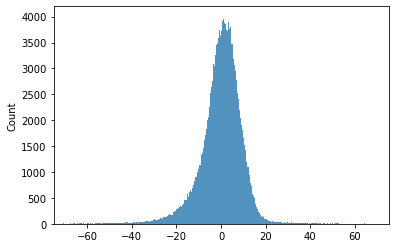

In [18]:
s_price = df_EI['day_ahead_price']

s_err = s_pred_ts - s_price.loc[s_pred_ts.index]

sns.histplot(s_err)
plt.xlim(-75, 75)

<br>

Now we'll calculate some error metrics, including the option to remove extreme error outliers

In [19]:
#exports
def calc_error_metrics(s_err, max_err_quantile=1):
    if s_err.isnull().sum() > 0:
        s_err = s_err.dropna()
        
    max_err_cutoff = s_err.abs().quantile(max_err_quantile)
    s_err = s_err[s_err.abs()<=max_err_cutoff]
    
    metrics = {
        'median_abs_err': s_err.abs().median(),
        'mean_abs_err': s_err.abs().mean(),
        'root_mean_square_error': np.sqrt((s_err**2).mean())
    }
    
    return metrics

In [20]:
metrics = calc_error_metrics(s_err)

metrics

{'median_abs_err': 5.048415483657855,
 'mean_abs_err': 7.0850025549996545,
 'root_mean_square_error': 12.400136353053382}

In [32]:
#exports
def get_model_pred_ts(s, model_fp, s_demand=None):
    df_pred = construct_df_pred(model_fp)
    s_cleaned = s.dropna().loc[df_pred.columns.min():df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]
    s_pred_ts = construct_pred_ts(s_cleaned, df_pred)
    
    if s_demand is None:
        return s_pred_ts
    else:
        s_cleaned = s_demand.dropna().loc[df_pred.columns.min():df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]
        s_pred_ts_demand = construct_pred_ts(s_cleaned, df_pred)
        return s_pred_ts, s_pred_ts_demand

In [96]:
s_demand = df_EI['demand']
s_price = df_EI['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

model_runs = {
#     'demand_p50': {
#         'model_fp': '../data/models/DAM_price_demand_p50.pkl',
#         's': s_demand
#     },
#     'demand_avg': {
#         'model_fp': '../data/models/DAM_price_demand_average.pkl',
#         's': s_demand
#     },
    'dispatch_p50': {
        'model_fp': '../data/models/DAM_price_p50.pkl',
        's': s_dispatchable,
        's_demand': s_demand
    },
#     'dispatch_avg': {
#         'model_fp': '../data/models/DAM_price_average.pkl',
#         's': s_dispatchable
#     },
}

model_outputs = dict()

for model_name, model_kwargs in track(model_runs.items()):
    s_pred_ts = get_model_pred_ts(**model_kwargs)
#     s_err = s_pred_ts - s_price.loc[s_pred_ts.index]
#     metrics = calc_error_metrics(s_err)
    
#     model_outputs[model_name] = {
#         's_pred_ts': s_pred_ts,
#         's_err': s_err,
#         'metrics': metrics
#     }

 [████████████████████████████████████████████████████████████] 1/1 [14:33<14:33, 873.11s/it]

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 209485/209485 [08:51<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 209688/209688 [05:34<00:00, 0.00s/it]

In [23]:
df_metrics = pd.DataFrame({
    name: outputs['metrics'] 
    for name, outputs 
    in model_outputs.items()
})

df_metrics

,demand_p50,demand_avg,dispatch_p50,dispatch_avg
median_abs_err,4.703768,5.048415,4.472330,4.776739
mean_abs_err,6.969523,7.085003,6.553057,6.648375
root_mean_square_error,12.622038,12.400136,12.047657,11.802395


In [24]:
old_err = df_metrics.loc['mean_abs_err', 'dispatch_avg']
new_err = df_metrics.loc['mean_abs_err', 'dispatch_p50']

print(f'{-100*(new_err - old_err)/old_err:.2f}% mean absolute error reduction using the p50 model rather than the average model')

1.43% mean absolute error reduction using the p50 model rather than the average model


In [29]:
old_err = df_metrics.loc['mean_abs_err', 'demand_p50']
new_err = df_metrics.loc['mean_abs_err', 'dispatch_p50']

print(f'{-100*(new_err - old_err)/old_err:.2f}% mean absolute error reduction using the dispatchable demand model rather than just demand')

5.98% mean absolute error reduction using the dispatchable demand model rather than just demand


<br>

### Quantifying the Merit Order Effect

Based on the results in the previous section we'll use the p50 model.

To begin we'll load up our dispatchable supply model results

In [97]:
(s_pred_ts, s_pred_ts_demand) = s_pred_ts#model_outputs['dispatch_p50']['s_pred_ts']

s_pred_ts

local_datetime
2009-01-01 00:00:00+00:00    37.203441
2009-01-01 00:30:00+00:00    37.313379
2009-01-01 01:00:00+00:00    36.768513
2009-01-01 01:30:00+00:00    35.595162
2009-01-01 02:00:00+00:00    34.849422
                               ...    
2020-12-29 21:30:00+00:00    40.827919
2020-12-29 22:00:00+00:00    39.509967
2020-12-29 22:30:00+00:00    37.836483
2020-12-29 23:00:00+00:00    36.383086
2020-12-29 23:30:00+00:00    35.436797
Length: 209485, dtype: float64

<AxesSubplot:xlabel='local_datetime'>

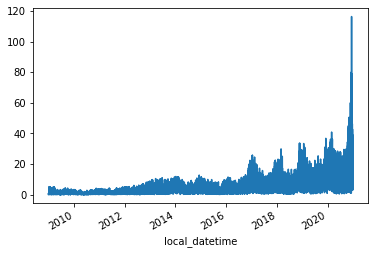

In [394]:
s_MOE = s_pred_ts_demand - s_pred_ts
s_MOE = s_MOE.dropna()

s_MOE.plot()

<br>

The demand is also expressed in terms of GW which we'll convert into MWh to be compatible with the units of the merit order effect.

<AxesSubplot:xlabel='local_datetime'>

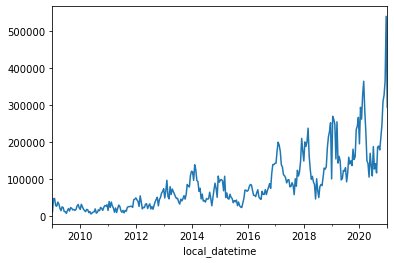

In [111]:
s_saving = s_MOE * df_EI['demand'].loc[s_MOE.index]*1000*0.5

s_saving.resample('2W').mean().plot()

(0.0, 750000.0)

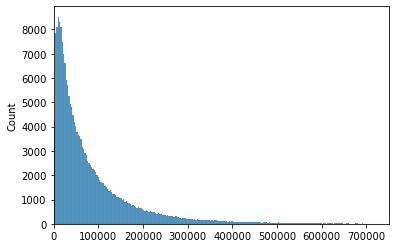

In [114]:
sns.histplot(s_saving)
plt.xlim(0, 750000)

In [115]:
s_saving.sum()

17838623385.23887

In [120]:
s_dam_cost = df_EI['day_ahead_price']*df_EI['demand']*1000*0.5

s_dam_cost.mean()

784440.8559554707

In [116]:
s_MOE.mean()/df_EI['day_ahead_price'].mean()

0.11125969014871903

<AxesSubplot:xlabel='local_datetime'>

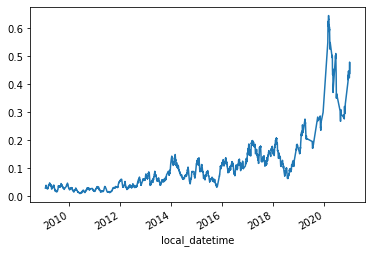

In [377]:
# expressing the reduction relative to the average price makes it easier to compare between markets
# n.b. this doesn't ease comparison between markets with different percentages of wind penetration
# could plot the paths of countries in terms of this ratio against wind penetration

s_MOE_rolling = s_MOE.rolling(48*28).mean().dropna()
s_DAM_rolling = s_MOE.rolling(48*28).mean().dropna()
s_wind_rolling = df_EI.loc[s_MOE.index]['day_ahead_price'].rolling(48*28).mean().dropna()

s_MOE_pct_reduction = s_MOE_rolling/s_DAM_rolling

s_MOE_pct_reduction.plot()

Text(0, 0.5, 'Average MOE Price Reduction (%)')

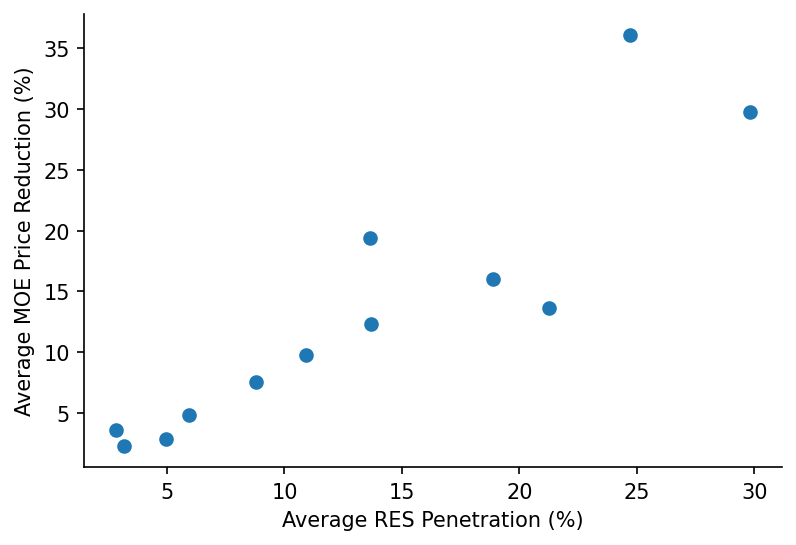

In [421]:
s_MOE_pct_annual_avg = (s_MOE/df_EI.loc[s_MOE.index]['day_ahead_price']).replace(np.inf, np.nan).dropna().pipe(lambda s: s.groupby(s.index.year).mean())
s_RES_pct_annual_avg = (df_EI[['wind', 'solar']].sum(axis=1)/df_EI['demand']).pipe(lambda s: s.groupby(s.index.year).mean())

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(100*s_RES_pct_annual_avg, 100*s_MOE_pct_annual_avg)

hlp.hide_spines(ax)
ax.set_xlabel('Average RES Penetration (%)')
ax.set_ylabel('Average MOE Price Reduction (%)')

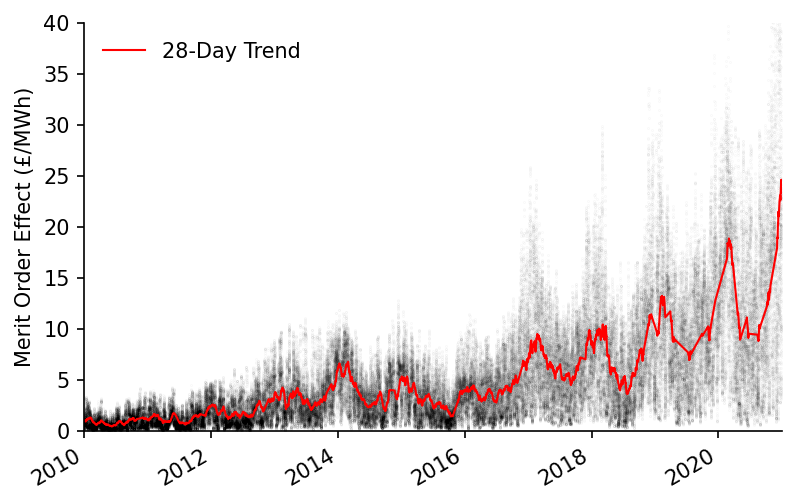

In [376]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_MOE.index, s_MOE, s=0.01, alpha=0.1, color='k', label=None)
s_MOE_rolling.plot(color='r', linewidth=1, ax=ax, label='28-Day Trend')

hlp.hide_spines(ax)
ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)

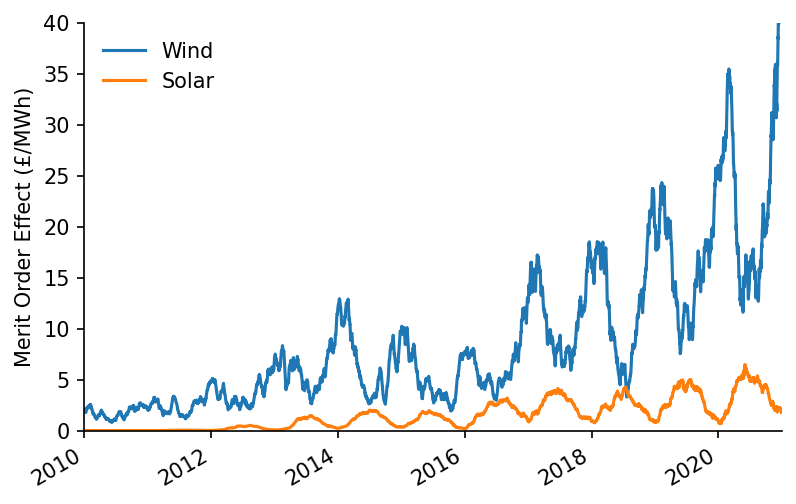

In [402]:
wind_weight = df_EI.loc[s_MOE.index, 'wind']/df_EI.loc[s_MOE.index][['wind', 'solar']].mean(axis=1)
solar_weight = df_EI.loc[s_MOE.index, 'solar']/df_EI.loc[s_MOE.index][['wind', 'solar']].mean(axis=1)

s_wind_MOE = s_MOE*wind_weight
s_solar_MOE = s_MOE*solar_weight

# Plotting
fig, ax = plt.subplots(dpi=150)

s_wind_MOE.rolling(48*28).mean().plot(ax=ax, label='Wind')
s_solar_MOE.rolling(48*28).mean().plot(ax=ax, label='Solar')

ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)
hlp.hide_spines(ax)

Text(0, 0.5, 'Price (£/MWh)')

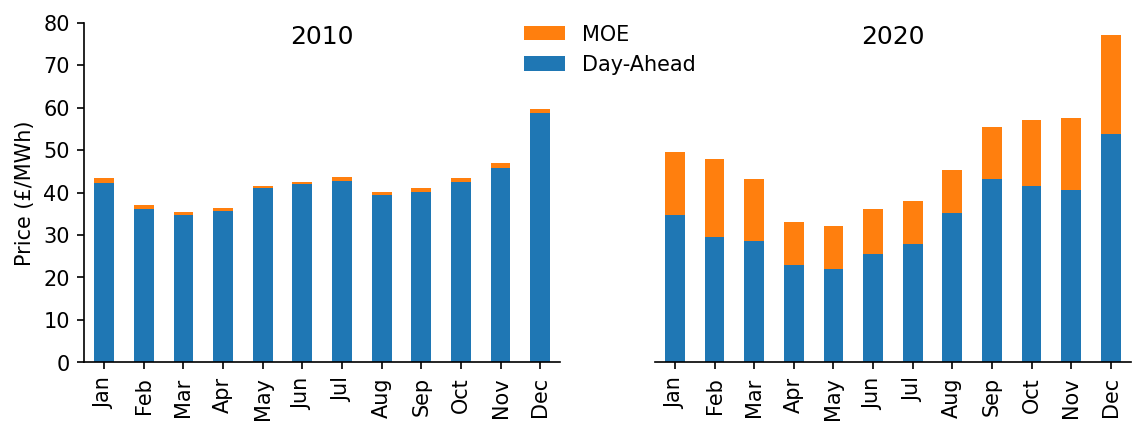

In [264]:
year_1 = '2010'
year_2 = '2020'

month_num_to_name = dict(zip(np.arange(1, 13), pd.date_range('2010-01-01', '2010-12-31', freq='M').strftime('%b')))

s_hourly_dam_10 = s_dam[year_1].groupby(s_dam[year_1].index.month).mean()
s_hourly_MOE_10 = s_MOE[year_1].groupby(s_MOE[year_1].index.month).mean()

s_hourly_dam_20 = s_dam[year_2].groupby(s_dam[year_2].index.month).mean()
s_hourly_MOE_20 = s_MOE[year_2].groupby(s_MOE[year_2].index.month).mean()

for s in [s_hourly_dam_10, s_hourly_MOE_10, s_hourly_dam_20, s_hourly_MOE_20]:
    s.index = s.index.map(month_num_to_name)

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(9, 3))

(s_hourly_dam_10+s_hourly_MOE_10).plot.bar(color='C1', label='MOE', ax=axs[0])
s_hourly_dam_10.plot.bar(label='Price', ax=axs[0])

(s_hourly_dam_20+s_hourly_MOE_20).plot.bar(color='C1', label='MOE', ax=axs[1])
s_hourly_dam_20.plot.bar(label='Day-Ahead', ax=axs[1])

axs[0].set_title(year_1, y=0.9)
axs[1].set_title(year_2, y=0.9)

for ax in axs:
    hlp.hide_spines(ax)
    ax.set_ylim(0, 80)
    ax.set_xlabel('')
    
axs[1].legend(frameon=False, bbox_to_anchor=(0.125, 1.05))
axs[1].set_yticks([])
hlp.hide_spines(axs[1], positions=['left'])

axs[0].set_ylabel('Price (£/MWh)')

<br>

### Wind Capture-Value Ratio

Now we'll turn our focus to calculating the capture-value ratio of wind over time

In [316]:
s_wind = df_EI[['day_ahead_price', 'wind']].dropna()['wind']
s_dam = df_EI[['day_ahead_price', 'wind']].dropna()['day_ahead_price']

In [331]:
#exports
def weighted_mean_s(s, s_weight=None, dt_rng=pd.date_range('2009-12-01', '2021-01-01', freq='W'), end_dt_delta_days=7):
    capture_prices = dict()

    for start_dt in dt_rng:
        end_dt = start_dt + pd.Timedelta(days=end_dt_delta_days)
        
        if s_weight is not None:
            weights = s_weight[start_dt:end_dt]
        else:
            weights=None
            
        capture_prices[start_dt] = np.average(s[start_dt:end_dt], weights=weights)

    s_capture_prices = pd.Series(capture_prices)
    s_capture_prices.index = pd.to_datetime(s_capture_prices.index)

    return s_capture_prices

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


<AxesSubplot:>

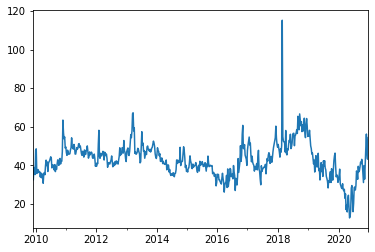

In [332]:
s_wind_capture_prices = weighted_mean_s(s_dam, s_wind)
s_dam_prices = weighted_mean_s(s_dam)

s_wind_capture_prices.plot()

-0.028


<AxesSubplot:ylabel='Count'>

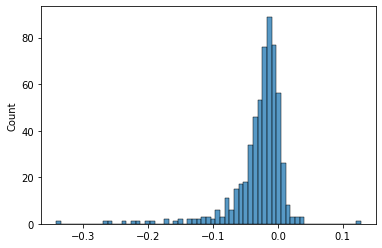

In [314]:
s_wind_capture_value_ratio = (s_wind_capture_prices - s_dam_prices)/s_dam_prices

print(round(s_wind_capture_value_ratio.mean(), 4))
sns.histplot(s_wind_capture_value_ratio)

Text(0, 0.5, 'Wind Capture Price Suppression (%)')

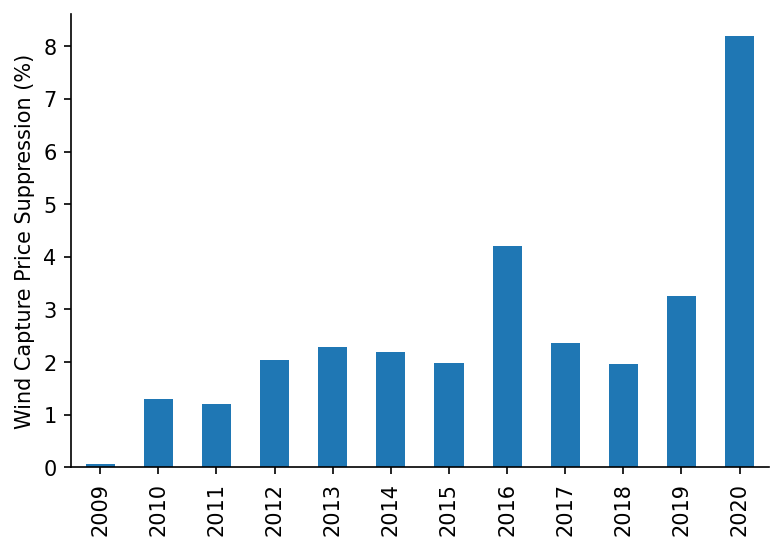

In [315]:
fig, ax = plt.subplots(dpi=150)

(-100*s_wind_capture_value_ratio.groupby(s_wind_capture_value_ratio.index.year).mean()).plot.bar(ax=ax)

hlp.hide_spines(ax)
ax.set_ylabel('Wind Capture Price Suppression (%)')

In [26]:
# repeat for UK carbon intensity
# download DE data for calc'ing MOE of price and carbon intensity 
# should use carbon intensity of the fleet which doesnt include wind and solar - which lower it!

# re-run the analysis using the % share of VRE
# what is the difference in terms of the cumulative MOE?

# re-run the skopt analysis
# clean up the hyper-parameter tuning surface plot

# work out and write the relevant LaTeX equations for both the MOE calculations and the LOWESS calculations

> This effect further intensifies as more VRE is added to the market, which gives rise to the term that VRE ‘cannibalises’ its own revenues. This is also described as the ‘capture-value’ effect, referring to the ratio of the average price received by VRE (weighted by their output) relative to the average market price (i.e. the value they capture). - [source](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3741232)

> The merit-order effect is typically expressed in absolute terms: the change in price for a fixed increase in VRE output (e.g. €/MWh per GW of output). However, we study power systems with very different scales, from an average load of 90 GW in the US PJM market down to less than 1 GW in Latvia and Estonia. Adding a fixed amount of VRE in small systems will have a greater effect. To harmonise for market size we present values in the units of €/MWh per 1 percentage point (ppt.) change in the share of VRE in generation, which we refer to as the ‘relative merit-order effect’ - [source](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3741232)

In [27]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
Converted 04-surface-estimation.ipynb.
Converted 05-merit-order-effect.ipynb.
